## Imports

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

#from google.colab import drive
#drive.mount('/content/drive/')

## Load/Show Functions

In [2]:
def load_images_from_folder(folder_path,height=200, width=200):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    
    for filename in filenames:
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            images.append(img)
    return images

In [3]:
def load_image_data_into_dataframe(folderpath):
    filenames = [f for f in os.listdir(folder_path)]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    
    for filename in filenames:
        parsed_name = filename.split('_')
        df = df.append({'age' : int(parsed_name[0])
                       #,'gender' : parsed_name[1],
                       #'race' : parsed_name[2]
                        }, ignore_index=True)
        
    #df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    #df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    
    return df

In [4]:
def show_images(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Age: {img_df.iloc[i]["age"]}; Race: {img_df.iloc[i]["race"]} Index: {i}',
                  fontweight="bold",fontsize=15)
        plt.imshow(img)

## Dataset Loading

In [5]:
folder_path = "../raw_data/UTKFace/"

In [6]:
!pwd

/home/fruntxas/code/felixfa/AgeDetection/notebooks


In [16]:
# Loading the Images 
X=load_images_from_folder(folder_path,height=100, width=100)
print("Images Loaded")

Images Loaded


In [9]:
# Loading the 3 features
features = load_image_data_into_dataframe(folder_path)
print("Dataframe Loaded")

Dataframe Loaded


In [10]:
print(len(X))
#print(images[0].shape)
print(len(features))

22006
22006


## Visualization

In [ ]:
#show_images(images[500:520],features.iloc[500:520])

## Distribution

In [ ]:
f = plt.figure(figsize=(25,15))
bins_value=[1,5,19,25,27,30,34,39,49,59,80]
bins_value=[1,2,5,11,19,24,26,27,29,31,34,36,39,44,50,55,61,70,80]
#bins_value = list(range(0,85,5))

# Age Histogram
f.add_subplot(211)
sns.histplot(data=features,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(features['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

# Race Histogram
f.add_subplot(224)
sns.histplot(features['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

## Variable Setup

**1**. Flatten the images **(200,200,3)**
2. Labelling the target **1st Model (Age).**
3. PCA-Only Analysis
4. Splitting the Data
Later. Age is to be binned on **5y intervals** ([1,5],[6,10],[11,15],...,...,[76,80])
Later. To check: Verify if **(Age, Sex and Race)** can also be used as inputs

### 1. Flatenning

In [17]:
img_array = np.array(X)

In [18]:
X = img_array.reshape(22006, img_array.shape[1]*img_array.shape[2]*img_array.shape[3])
X.shape

(22006, 30000)

In [21]:
del img_array

### 2. Labeling Age

In [19]:
features['age_group'] = pd.cut(features['age'],16,precision=0).astype(str)
y = features['age_group'].map({
    '(1.0, 6.0]' : 0,'(6.0, 11.0]' : 1,
    '(11.0, 16.0]': 2,'(16.0, 21.0]': 3,
    '(21.0, 26.0]':4,'(26.0, 31.0]':5,
    '(31.0, 36.0]':6,'(36.0, 40.0]':7,
    '(40.0, 45.0]':8,'(45.0, 50.0]':9,
    '(50.0, 55.0]':10,'(55.0, 60.0]':11,
    '(60.0, 65.0]':12,'(65.0, 70.0]':13,
    '(70.0, 75.0]':14,'(75.0, 80.0]':15
    })

In [20]:
del features

NameError: name 'lbl' is not defined

## 3. PCA-Only Analysis

#### Incremental PCA on partial_fit

In [22]:
from sklearn.decomposition import IncrementalPCA

In [24]:
X.shape

(22006, 30000)

In [25]:
num_rows, num_columns = X.shape
batch_size = 1000     # how many rows at a time to feed ipca
n_components = 400

pca = IncrementalPCA(copy=False,
                  n_components=n_components)
                  #,batch_size=(num_rows // n_batches))

print(num_rows // batch_size) 

22


In [26]:
for i in range(0, num_rows//batch_size):
    print(i,"/",num_rows//batch_size)
    pca.partial_fit(X[i*batch_size : (i+1)*batch_size])

0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22


In [33]:
import joblib
!ls

Streaming output truncated to the last 5000 lines.
 50_0_1_20170117135655702.jpg.chip.jpg
 50_0_1_20170117154528349.jpg.chip.jpg
 50_0_1_20170117164310665.jpg.chip.jpg
 50_0_1_20170117172803693.jpg.chip.jpg
 50_0_1_20170117173404026.jpg.chip.jpg
 50_0_1_20170117173418899.jpg.chip.jpg
 50_0_1_20170117173432690.jpg.chip.jpg
 50_0_1_20170117173743345.jpg.chip.jpg
 50_0_1_20170117175738076.jpg.chip.jpg
 50_0_1_20170117181702370.jpg.chip.jpg
 50_0_1_20170117184611832.jpg.chip.jpg
 50_0_1_20170117204159441.jpg.chip.jpg
 50_0_1_20170120220929108.jpg.chip.jpg
 50_0_1_20170120221000756.jpg.chip.jpg
 50_0_1_20170120221415661.jpg.chip.jpg
 50_0_1_20170120222239167.jpg.chip.jpg
 5_0_0_20170103205053570.jpg.chip.jpg
 5_0_0_20170109192317486.jpg.chip.jpg
 5_0_0_20170109192353674.jpg.chip.jpg
 5_0_0_20170109193414770.jpg.chip.jpg
 5_0_0_20170110212657381.jpg.chip.jpg
 5_0_0_20170110212757355.jpg.chip.jpg
 5_0_0_20170110212804775.jpg.chip.jpg
 5_0_0_20170110212809381.jpg.chip.jpg
 5_0_0_20170110212834

In [144]:
%cd /content/drive/MyDrive/pca_files

/content/drive/MyDrive/pca_files


In [145]:
joblib.dump(pca,"pca_245.pkl")

['pca_245.pkl']

In [201]:
data_projected = np.zeros((num_rows,n_components))

In [ ]:
data_projected.shape

(22006, 500)

In [ ]:
for i in range(0,200):#num_rows//batch_size):
    data_projected[i*batch_size:(i+1) * batch_size] = pca.transform(X[i*batch_size : (i+1)*batch_size])

#### TruncatedSVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=250)

In [ ]:
svd.fit(images_input)#[:1000])

In [ ]:
data_projected = svd.transform(images_input)#[:1000])

### Model Saving

In [14]:
import joblib

In [ ]:
!ls

drive  sample_data  UTKFaces


In [ ]:
model_name = "ipca_"+str(n_components)+".joblib"
joblib.dump(pca, model_name)

['ipca_1000.joblib']

### 3. PCA Analysis

#### 3.1 PCA Reconstruction

In [ ]:
#data_reconstruced = pca.inverse_transform(data_projected[:200])
#data_reconstruced.shape

In [ ]:
data_reconstruced = np.zeros((num_rows,num_columns))

In [ ]:
for i in range(0,num_rows//chunk_size):
    data_reconstruced[i*chunk_size:(i+1) * chunk_size] = pca.inverse_transform(data_projected[i*chunk_size : (i+1)*chunk_size])

In [ ]:
plt.imshow((data_reconstruced[110].reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3]))).astype(np.uint8))

In [ ]:
plt.imshow(images[110])

#### 3.2 PCA Mean Faces

In [28]:
plt.imshow(np.mean(X,axis=0).reshape((X.shape[1],X.shape[2],X.shape[3])).astype(np.uint8))
plt.title("Mean Face of the Input")

IndexError: tuple index out of range

In [29]:
plt.imshow(pca.mean_.reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3])).astype(np.uint8))
plt.title("Mean Face of the PCA")

NameError: name 'img_array' is not defined

In [17]:
!ls drive/MyDrive/pca_files/

pca_245.pkl		X_train_transformed.npy  y_train.npy
X_test_transformed.npy	y_test.npy


In [50]:
import joblib


In [51]:
joblib.dump(pca,"/content/drive/MyDrive/pca_files/pca_245.pkl")

['/content/drive/MyDrive/pca_files/pca_245.pkl']

In [21]:
components = pca.components_ * pca.mean_

In [29]:
pca.components_.reshape(245,200,200,3)[:,:,:,0].shape

(245, 200, 200)

In [ ]:
pd.DataFrame(pca.mean_)

In [22]:
components[0]

array([0.27534697, 0.21981213, 0.18746323, ..., 0.39085442, 0.33074026,
       0.30713066])

#### 3.3 PCA Components

ValueError: cannot reshape array of size 12000000 into shape (100,100,3)

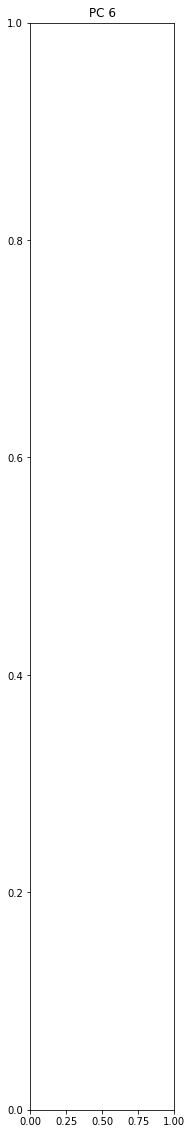

In [33]:
fig = plt.figure(figsize=(15,20))
for i,j in enumerate(range(5,9)):
    plt.subplot(1, 5, i + 1)
    plt.title(f'PC {j+1}', size=12)
    plt.imshow(pca.components_.reshape(100,100,3)[j], cmap=plt.cm.coolwarm)
    #plt.imshow(components[j].reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3])).astype(np.uint8))

200

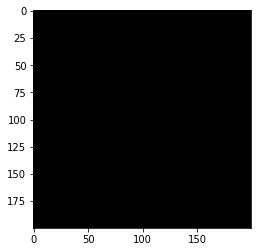

In [186]:
plt.imshow(pca.components_[0].reshape(200,200,3).astype(np.uint8), cmap="gray")
img_array.shape[2]

In [160]:
21600/

21600

#### 3.4 Choosing the number of PCA Components

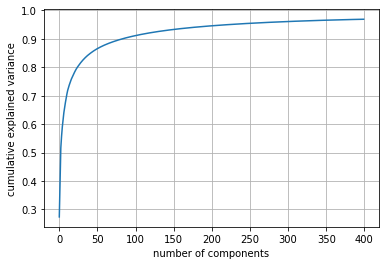

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [35]:
#Minimal Number of PC components required to explain g variance

g = 0.95

cumulated_variance = np.cumsum(pca.explained_variance_ratio_)
minimal_pc_count = len(cumulated_variance[cumulated_variance <= g]) + 1 # fill with the right answer
minimal_pc_count

225

## 4 Splitting the Data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [37]:
del X,y

## 5. Classifying the Data

### 5.1 PCA fit on the train set and transform on both

In [38]:
from sklearn.decomposition import IncrementalPCA

In [39]:
num_rows

22006

In [40]:
num_rows, num_columns = X_train.shape
chunk_size = 1000      # how many rows at a time to feed ipca
n_components = 245    # 245 explains 95% variance on the 200x200 RBG Images

pca = IncrementalPCA(copy=False,
                  n_components=n_components
                  )

In [41]:
# Partial Fitting on X_train
for i in range(0, num_rows//chunk_size):
    print(i,"/",num_rows//chunk_size)
    pca.partial_fit(X_train[i*chunk_size : (i+1)*chunk_size])

pca.partial_fit(X_train[(num_rows//chunk_size*chunk_size):])

0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17


IncrementalPCA(copy=False, n_components=245)

In [45]:
del images

In [42]:
# Initializing X_train and X_test for transformation
X_train_transformed = np.zeros((X_train.shape[0],245))
X_test_transformed = np.zeros((X_test.shape[0],245))

In [66]:
chunk_size = 650 

In [ ]:
# Partial Transforming X_train
for i in range(0,X_train_transformed.shape[0]//chunk_size):
    print(i,"/",X_train_transformed.shape[0]//chunk_size)
    X_train_transformed[i*chunk_size:(i+1) * chunk_size] = pca.transform(X_train[i*chunk_size : (i+1)*chunk_size])

X_train_transformed[(num_rows//chunk_size*chunk_size):] = pca.transform(X_train[(num_rows//chunk_size*chunk_size):])

In [ ]:
# Partial Transforming X_test
chunk_size = 30
for i in range(0,X_test_transformed.shape[0]//chunk_size):
    print(i,"/",X_test_transformed.shape[0]//chunk_size)
    X_test_transformed[i*chunk_size:(i+1) * chunk_size] = pca.transform(X_test[i*chunk_size : (i+1)*chunk_size])

X_test_transformed[(X_test_transformed.shape[0]//chunk_size*chunk_size):] = pca.transform(X_test[(X_test_transformed.shape[0]//chunk_size*chunk_size):])

In [85]:
del X_train,X_test

### Saving the split

In [90]:
#np.save("/content/drive/MyDrive/pca_files/X_train_transformed.npy",X_train_transformed)
np.save("/content/drive/MyDrive/pca_files/X_test_transformed.npy",X_test_transformed)
np.save("/content/drive/MyDrive/pca_files/y_train.npy",y_train)
np.save("/content/drive/MyDrive/pca_files/y_test.npy",y_test)

## Loading transformed splits

In [2]:
pca_path = "../data/pca_files/"

In [3]:
X_test_transformed = np.load(pca_path+"X_test_transformed.npy")
X_train_transformed = np.load(pca_path+"X_train_transformed.npy")
y_test = np.load(pca_path+"y_test.npy")
y_train = np.load(pca_path+"y_train.npy")
print(X_train_transformed.shape)
print(X_test_transformed.shape)
print(y_train.shape)
print(y_test.shape)

(19805, 245)
(2201, 245)
(19805,)
(2201,)


### 5.2 CV GridSearch

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from catboost import CatBoostClassifier

#### Worst

In [14]:
accuracy = []

#criterion = 'gini' # 0.207
#splitter = 'best'
#min_samples_leaf = [8,10,13]

param_grid = {
     #,"min_samples_leaf": [40,70,100]
     #,"max_features":["auto","sqrt","log2"]
}

for i in [1]:
    print(i,"in","min_samples_leaf")
    # Random Forest -> 0.3386
    #model = RandomForestClassifier(n_estimators = 400, n_jobs = -1, criterion="entropy"
    #                                ,min_samples_split=4
    #                                ,min_samples_leaf=13)  
    # DecisionTree -> 0.231
    #model = DecisionTreeClassifier(criterion="entropy",min_samples_leaf=70,min_samples_split=70,splitter="best")      
    # RadiusNeighClassifier -> 0.164
    #model = RadiusNeighborsClassifier(radius = 16500,n_jobs=-1,outlier_label="most_frequent",weights='distance'
    #                                  ,p=1)
    # KNN -> 0.3 with n=22 (algo/leaf makes no diff)
    #model = KNeighborsClassifier(n_neighbors=22,weights="distance")
    
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    accuracy.append(accuracy_score(y_test,y_pred))

1 in min_samples_leaf


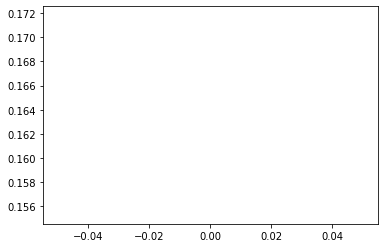

In [16]:
plt.plot(accuracy)

In [4]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(X_train_transformed)

#### Best (SVC)

In [ ]:
C = [10.75,11.25]         # C = 11 is good [10.5 - 11.5]
accuracy = []

#for i in C:
#    print(i,"in",C)
    
    # SVC
model = SVC(kernel="linear",class_weight="balanced",C = 11
            ,cache_size=2000,verbose=10)

model.fit(x, y_train)
y_pred = model.predict(X_test_transformed)
accuracy.append(accuracy_score(y_test,y_pred))

[LibSVM]

In [21]:
svc = SVC(kernel="rbf",class_weight="balanced",C = 10.5
            ,cache_size=2000,verbose=10)
model = AdaBoostClassifier(base_estimator=svc,n_estimators=100,algorithm="SAMME")
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
accuracy_score(y_test,y_pred)

[LibSVM]

ValueError: BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.

In [ ]:
import time
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

ovr_linear = OneVsRestClassifier(LinearSVC())
ovr_linear.fit(X_train_transformed, y_train)
end = time.time()
print "Single SVC", end - start, ovr_linear.score(X_test_transformed,y_test)
#proba = ovr_linear.predict_proba(X)

n_estimators = 10
start = time.time()
ovr_bag_lin = OneVsRestClassifier(BaggingClassifier(LinearSVC(), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
ovr_bag_lin.fit(X_train_transformed, y_train)
end = time.time()
print "Bagging SVC", end - start, ovr_bag_lin.score(X_test_transformed,y_test)
#proba = ovr_bag_lin.predict_proba(X)

start = time.time()
rfc = RandomForestClassifier(n_estimators = 400, n_jobs = -1, criterion="entropy"
                                    ,min_samples_split=4
                                    ,min_samples_leaf=13)
rfc.fit(X_train_transformed, y_train)
end = time.time()
print "Random Forest", end - start, rfc.score(X_test_transformed,y_test)
#proba = rfc.predict_proba(X)

#### SGDClassifier

In [29]:
model = SGDClassifier(n_jobs=-1)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
accuracy_score(y_test,y_pred)

0.16628805088596094

In [26]:
accuracy_score(y_test,y_pred)

0.3089504770558837

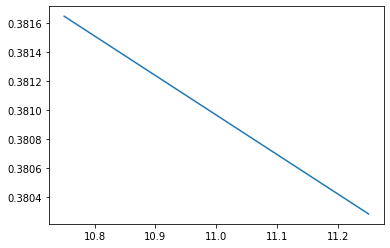

In [18]:
plt.plot(C,accuracy)

In [ ]:
#print(model.best_estimator_)
y_pred = model.predict(X_test_transformed)
print(accuracy_score(y_test,y_pred))

Confusion matrix:
[[128  21  19  10   2   9   7  11   8   5]
 [ 33  39  53  14  20  19  16   8  20  13]
 [ 18  30  81  32  26  34  15  17  19  21]
 [  8  20  48  22  16  19  32  27   6  10]
 [ 11  16  42  19  20  18  23  23  14   5]
 [ 10  19  44  20  12  25  27  26  17   6]
 [ 16  11  32  18   9  28  28  31  11  16]
 [ 14  17  32  17   8  17  33  36  20  16]
 [  8  12  19   8  12  15  26  28  40  33]
 [ 18  11  13  11  14  14  19  39  40  58]]


In [ ]:
# Fitting
model.fit(X_train_transformed, y_train)

In [ ]:
model.best_estimator_

### 5.3 GridSearch Classification Report

In [ ]:
pd.DataFrame(X_test_transformed)

In [35]:
y_pred = model.best_estimator_.predict(X_test_transformed)
pd.DataFrame(y_pred).value_counts()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.75      0.59       220
           1       0.31      0.19      0.23       235
           2       0.27      0.41      0.32       293
           3       0.24      0.11      0.15       208
           4       0.35      0.06      0.10       191
           5       0.14      0.08      0.10       206
           6       0.18      0.13      0.15       200
           7       0.19      0.20      0.19       210
           8       0.18      0.25      0.21       201
           9       0.30      0.48      0.37       237

    accuracy                           0.28      2201
   macro avg       0.26      0.27      0.24      2201
weighted avg       0.27      0.28      0.25      2201



In [113]:
y_pred

array([7, 7, 7, ..., 7, 7, 7])

In [36]:
from sklearn.metrics import accuracy_score

In [38]:
accuracy_score(y_test,y_pred)

0.2780554293502953

### 5.4 Further Improvement

In [ ]:
pipe = make_pipeline(PCA(),SVC(class_weight="balanced"))
param_grid = {
    "pca__n_components": range(200, 600, 1),
    "svc__kernel": ["linear"],
    "svc__C": [10],#[10, 20, 50, 100, 200, 500, 1000, 2000, 5000],
    "svc__gamma": [0.0001]#[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head(20)

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_estimator_.score(X_test, y_test)

In [ ]:
y_pred = clf.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
# Number of Components that give out the best score
best_n_components = clf.get_params()['pca__n_components']
best_n_components